In [ ]:
from collections import Counter
import nltk
import pandas as pd
from emoticons import EmoticonDetector
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

import matplotlib.pyplot as plt
%matplotlib inline

# plotly configuration
plotly.offline.init_notebook_mode()

In [ ]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "emotion", "text"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative", "neutral"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "text"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["text"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [ ]:
data = TwitterData_Initialize()
data.initialize("data\\train.csv")
data.processed_data.head(5)

In [80]:
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
neu = len(df[df["emotion"] == "neutral"])
dist = [
    graph_objs.Bar(
        x=["negative","neutral","positive"],
        y=[neg, neu, pos],
)]

In [81]:
#plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in training set")})

In [82]:
gR = df.groupby('emotion').size()
print(type(gR))
gR

<class 'pandas.core.series.Series'>


emotion
negative     956
neutral     2125
positive    2888
dtype: int64

<Container object of 3 artists>

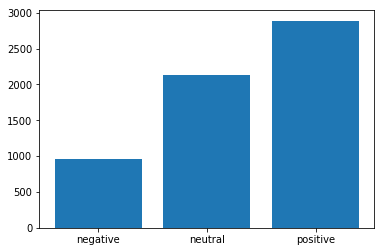

In [76]:
plt.bar(gR.index, gR)

In [83]:
def words(stringIterable):
    #upcast the argument to an iterator, if it's an iterator already, it stays the same
    lineStream = iter(stringIterable)
    for line in lineStream: #enumerate the lines
        for word in line.split(): #further break them down
            yield word
for word in data.processed_data.text:
    #print(word)
    for w in words([word]):
        #print(w)

SyntaxError: unexpected EOF while parsing (<ipython-input-83-45b0a9a34ff1>, line 10)

In [84]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "text"])

words.most_common(5)



[(' ', 102980), ('e', 48826), ('t', 43612), ('o', 38223), ('a', 38001)]

In [ ]:
import nltk
nltk.download()

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

In [41]:
def words(stringIterable):
    #upcast the argument to an iterator, if it's an iterator already, it stays the same
    lineStream = iter(stringIterable)
    for line in lineStream: #enumerate the lines
        for word in line.split(): #further break them down
            yield word
listOfLines = ['hi there', 'how are you']
for word in words(listOfLines):
    print(word)

hi
there
how
are
you


In [ ]:
class TwitterData_Wordlist(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("data\\wordlist.csv"):
            word_df = pd.read_csv("data\\wordlist.csv")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "text"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("data\\wordlist.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]

In [24]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)

In [26]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow.iloc[:, 0],
                                                    train_size=0.7, stratify=bow.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())

NameError: name 'bow' is not defined